https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

## Basic Imports

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## ART Imports

In [2]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

## Define A Torch Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

## Load MNIST

* Swap axes using `np.transpose` to PyTorches B x C x H x W (Batch Size x Number of Channels x Height x Width) format

In [4]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

## Create the Model


In [5]:
model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Generate an ART Classifier

In [6]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

## Train the Classifier

In [7]:
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

## Test on Benign Samples

In [8]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.92999999999999%


## Generate Adversarial Samples

In [9]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

 ## Test Against an Adversarial Attack!

In [10]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 20.43%


## Investigate

In [11]:
import matplotlib.pyplot as plt

In [12]:
print(type(x_test_adv))
print(x_test_adv.shape)

<class 'numpy.ndarray'>
(10000, 1, 28, 28)


In [13]:
sqrt_n_images = 10
n_images = sqrt_n_images**2

batch_size = x_test_adv.shape[0]
random_choice = np.random.choice(batch_size, n_images, replace=False)

plot_images_adv = x_test_adv[random_choice]

# Remove channel dimension
plot_images_adv = plot_images_adv.squeeze()


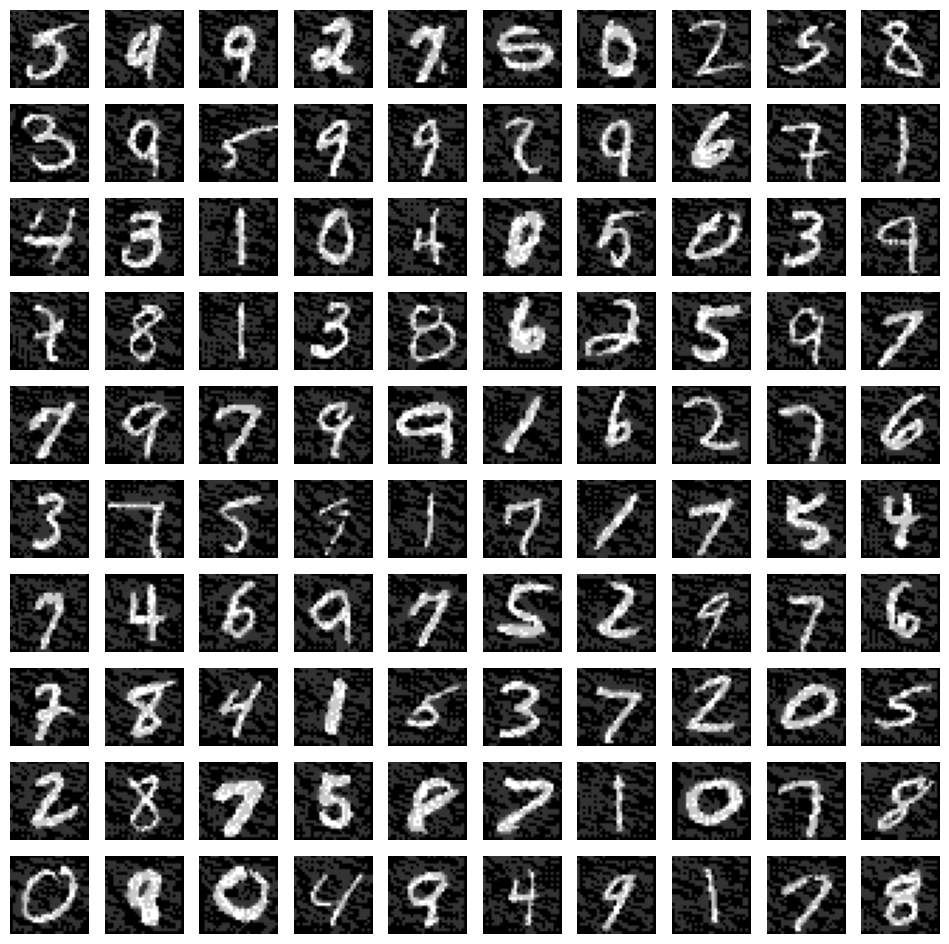

In [14]:

def show_images(images_array, sqrt_n_images):
    fig, axes = plt.subplots(sqrt_n_images, sqrt_n_images, figsize=(12, 12))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images_array[idx], cmap='gray')
        ax.axis('off')

show_images(plot_images_adv, sqrt_n_images)

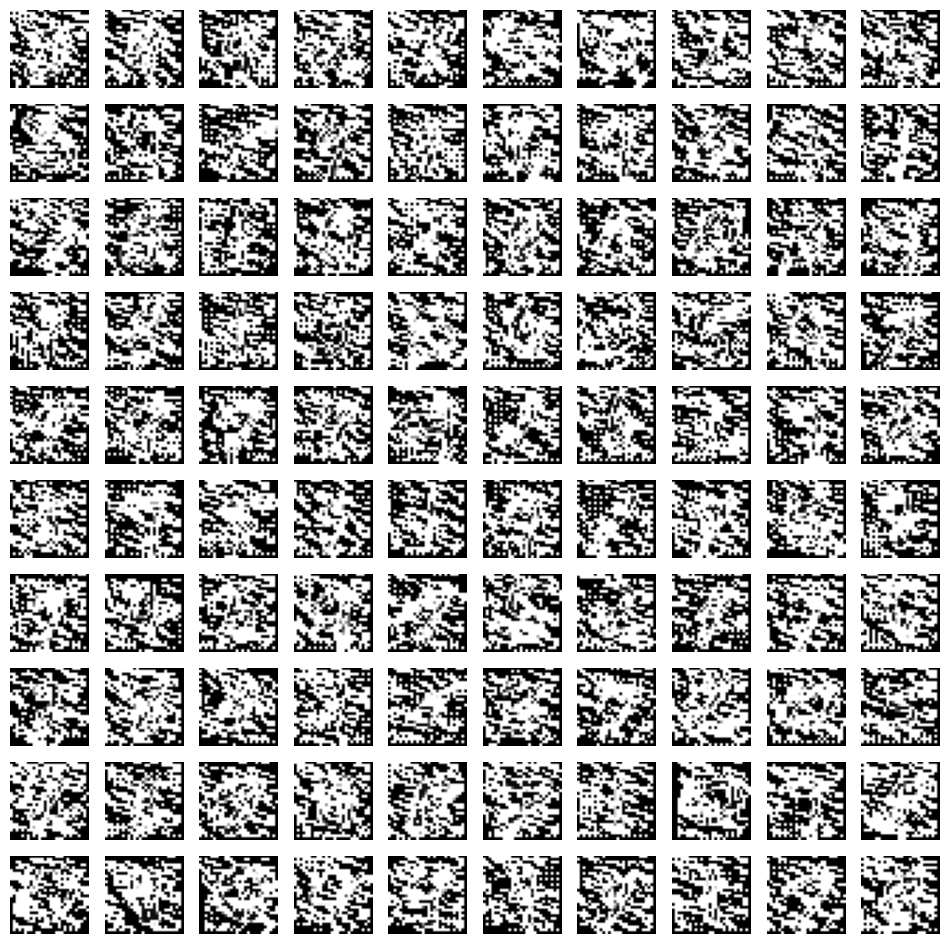

In [15]:
plot_images_benign = x_test[random_choice]
plot_images_benign = plot_images_benign.squeeze()

delta_images = np.abs(plot_images_benign - plot_images_adv)

show_images(delta_images, sqrt_n_images)

## Playing Defense

Is nonlinearity really the problem?

Accuracy on adversarial test examples with nonlinear transform inline: 86.22%


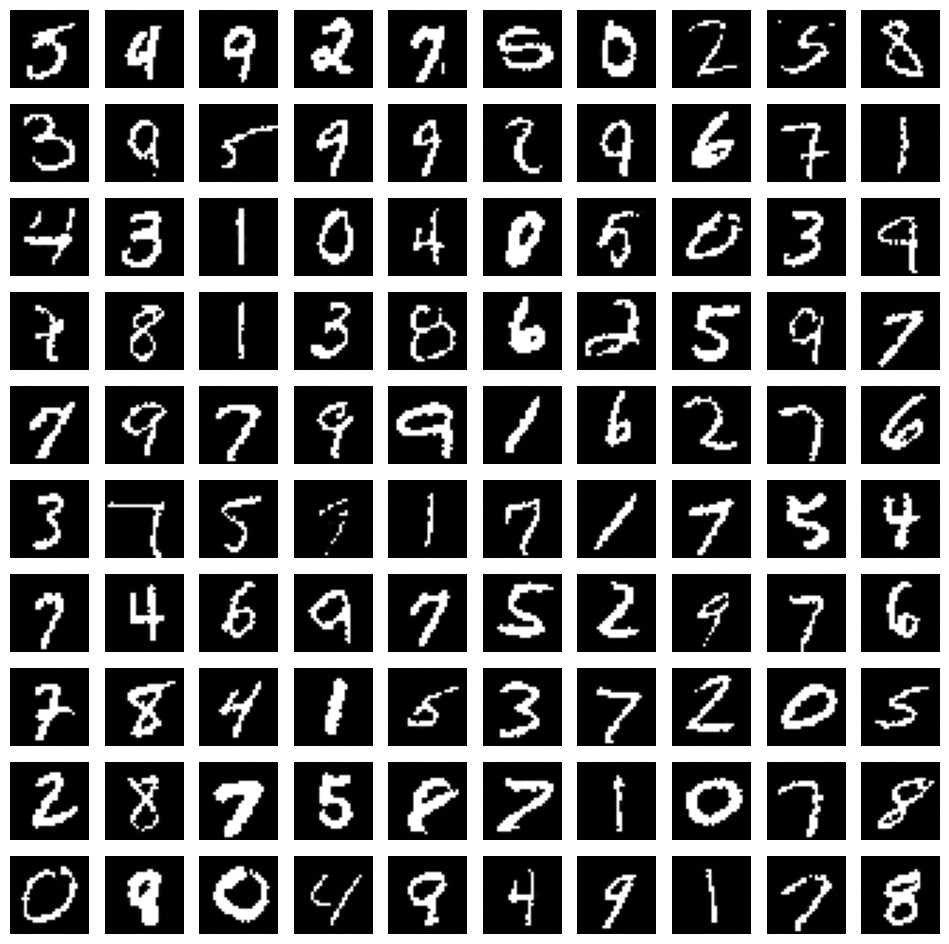

In [16]:
def nonlinear_transform(x):
    x = np.exp(5*x) # Bring any pixels close to 0 closer to full dark
    x[x > 20] = 255 # Bring any remaining bright pixels to white
    return x

x_test_def = nonlinear_transform(x_test_adv)

plot_images_def = x_test_def[random_choice]
plot_images_def = plot_images_def.squeeze()

predictions = classifier.predict(x_test_def)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples with nonlinear transform inline: {}%".format(accuracy * 100))

show_images(plot_images_def, sqrt_n_images)

## Train on the Transform

In [21]:
classifier_with_transform = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

x_train_transformed = nonlinear_transform(x_train)

classifier_with_transform.fit(x_train_transformed, y_train, batch_size=64, nb_epochs=10)

In [22]:
predictions = classifier_with_transform.predict(x_test_def)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 88.26%
